
# Intro

 This presents a proof of concept for a new application, pipe detection from aerial drone images.
 
 See the readme.md for more.

In [1]:
import os
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu,floatX=float32'

In [2]:
import skimage
from skimage import transform, color

from matplotlib import pyplot as plt
import numpy as np
# import pandas as pd
# import scipy as sp
import seaborn as sns
%matplotlib inline

# import h5py 
# import shapely
# from shapely import geometry, affinity

from path import Path
# import json
import arrow
from tqdm import tqdm

import keras
from keras.preprocessing import image

Using Theano backend.
Using gpu device 0: GeForce GTX 860M (CNMeM is disabled, cuDNN 4007)


In [3]:
plt.rcParams['figure.figsize']=(10,10)

In [4]:
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

# Test we have my PR to keras

Note this uses Keras with my prs

- https://github.com/fchollet/keras/pull/3751 (merged>1.0.9)
- https://github.com/fchollet/keras/pull/3871
```sh
pip install https://github.com/wassname/keras/archive/patch-1.zip
```

In [7]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')

data_gen_args=dict(horizontal_flip=True,vertical_flip=True,rotation_range=90.,width_shift_range=0.2,
                 height_shift_range=0.2, zoom_range=0.2,)
datagen1 = ImageDataGenerator(**data_gen_args)
datagen2 = ImageDataGenerator(**data_gen_args)

seed=1
batch_size=3
gen1=datagen1.flow(X_train, y_train, batch_size=batch_size ,seed=seed, shuffle=True)
gen2=datagen2.flow(X_train, y_train, batch_size=batch_size, seed=seed, shuffle=True)


for i in range(10):
    X_train1, y_train1=next(gen1)
    X_train2, y_train2=next(gen2)
    for b in range(batch_size-1):
        assert (X_train1[b]==X_train2[b]).all()
        assert (y_train1[b]==y_train2[b]).all()
print('✓ ImageDataGenerator is repeatable')

✓ ImageDataGenerator is repeatable


# Load data

Our source data are split 1:2 for testing and training. These where augumented by:

- random rotations up to 360 degrees
- up to 80% horizontal and vertical translations
- zoom of 80%
- shear of up to 10 degrees
- jitter of 1% for each color channel

Then resized to 80x112 for training.

In [8]:
img_rows = 80
img_cols = 112
batch_size=10
output_shape=(img_rows,img_cols)

In [12]:
dest_dir = Path('./data/augumented/train')
dest_dir_test = Path('./data/augumented/test')

# make sure image match
images=sorted(dest_dir.glob('image/*.png'))
masks=sorted(dest_dir.glob('mask/*.png'))
assert len(dest_dir.glob('image/*.png'))==len(dest_dir.glob('mask/*.png')), 'should be same number of pngs'
for i,[image,mask] in enumerate(zip(images,masks)):
    assert image.basename()==mask.basename(),'i=%s %s!=%s'%(i,image.basename(),mask.basename())

In [13]:
data_gen_args=dict(
                rotation_range=10.,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=np.deg2rad(10),
                zoom_range=0.1,
                channel_shift_range=0.01,
                fill_mode='constant',
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1/255.
)

datagen1 = ImageDataGenerator(**data_gen_args)
datagen2 = ImageDataGenerator(**data_gen_args)

image_gen=datagen1.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['image'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )
mask_gen=datagen2.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['mask'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )


# join the generators (converting the mask to greyscale)
def dual_gen(image_gen,mask_gen):
    for image,mask in zip(image_gen,mask_gen):
        mask=skimage.color.rgb2grey(np.transpose(mask,(0,2,3,1)))
        yield image,mask

train_gen=dual_gen(image_gen,mask_gen)

X_train, y_train=next(train_gen)
X_train.shape, y_train.shape

Found 3870 images belonging to 1 classes.
Found 3870 images belonging to 1 classes.


((10, 3, 80, 112), (10, 80, 112))

In [14]:
# test gen
data_gen_args=dict(
                fill_mode='constant',
                rescale=1/255.
)

datagen_test1 = ImageDataGenerator(**data_gen_args)
datagen_test2 = ImageDataGenerator(**data_gen_args)

image_gen_test=datagen_test1.flow_from_directory(dest_dir_test, 
                                  class_mode=None, 
                                  classes=['image'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )
mask_gen_test=datagen_test2.flow_from_directory(dest_dir_test, 
                                  class_mode=None, 
                                  classes=['mask'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )

# join the generators
def dual_gen(image_gen,mask_gen):
    for image,mask in zip(image_gen,mask_gen):
        mask=skimage.color.rgb2grey(np.transpose(mask,(0,2,3,1)))
        yield image,mask

test_gen=dual_gen(image_gen_test,mask_gen_test)

X_test, y_test=next(test_gen)
X_test.shape, y_test.shape

Found 503 images belonging to 1 classes.
Found 503 images belonging to 1 classes.


((10, 3, 80, 112), (10, 80, 112))

In [63]:
# train gen, but this time un-augumented so I can directly compare them for overfitting
data_gen_args=dict(
                fill_mode='constant',
                rescale=1/255.
)

datagen_test1b = ImageDataGenerator(**data_gen_args)
datagen_test2b = ImageDataGenerator(**data_gen_args)

image_gen_train2=datagen_test1b.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['image'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )
mask_gen_train2=datagen_test2b.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['mask'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )

# join the generators
def dual_gen(image_gen,mask_gen):
    for image,mask in zip(image_gen,mask_gen):
        mask=skimage.color.rgb2grey(np.transpose(mask,(0,2,3,1)))
        yield image,mask

train_gen_unaugumented=dual_gen(image_gen_train2,mask_gen_train2)

X_test, y_test=next(train_gen_unaugumented)
X_test.shape, y_test.shape

Found 3870 images belonging to 1 classes.
Found 3870 images belonging to 1 classes.


((10, 3, 80, 112), (10, 80, 112))

Note: please check the images and mask match!

If they don't you probobly have the wrong version of keras. Use: `pip install https://github.com/wassname/keras/archive/patch-1.zip`

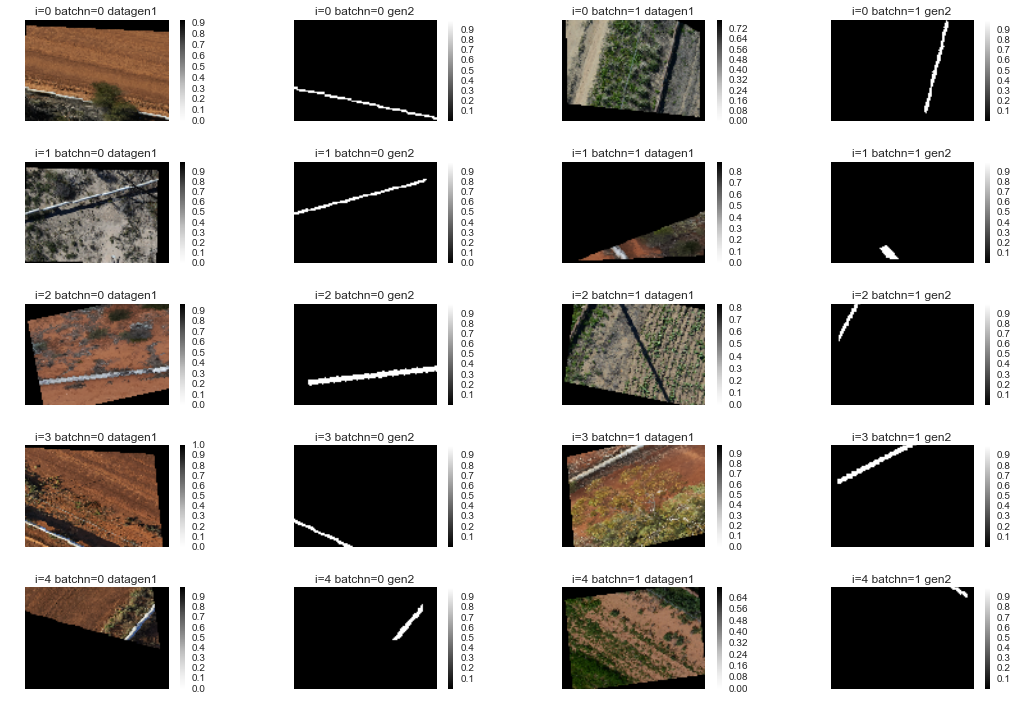

In [16]:
# View some of the data
seed=1
n=5
rows=n
cols=4

pltnb=0
plt.figure(figsize=(15,rows*2))
for i in range(n):
    X_train, y_train=next(train_gen)
    for b in range(2):
        # create a grid of 3x2
        pltnb+=1
        plt.subplot(rows,cols,pltnb)
        plt.title('i=%s batchn=%s datagen1'%(i,b))
        plt.imshow(np.transpose(X_train[b],(1,2,0)))
        plt.colorbar()
        plt.axis('off')


        pltnb+=1
        plt.subplot(rows,cols,pltnb)
        
        plt.title('i=%s batchn=%s gen2'%(i,b))
        plt.imshow(y_train[b], cmap=plt.get_cmap('gray'))
        plt.colorbar()
        plt.axis('off')
plt.tight_layout()
plt.show()

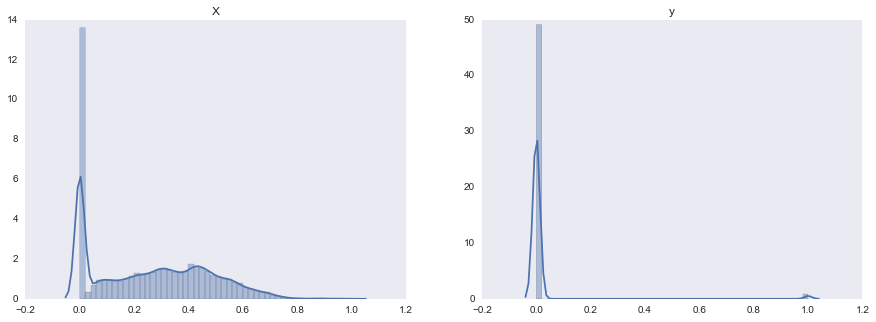

In [203]:
# show data dist
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(X_train.flatten())
plt.title('X')

plt.subplot(1,2,2)
sns.distplot(y_train.flatten())
plt.title('y')

# Metrics

We use the [Sørensen–Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) after transforming it to [0-1] and smoothing it to a ~L1 (linear) loss.

$$ L = 1-\frac{ 2 \sum_i|A_i B_i|+ \delta}{\sum_i A_i^2 + B_i^2 + \delta}$$

In [38]:
# define custom loss and metric functions 

from keras import backend as K
smooth = 1

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

# I think the missing one was a mistake, because it made loss(y_true,y_true)=-1
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# Model

![model_diagram](images/model_diagram.png)
*The model architecture. Each box is a inception module or convolution with the number of feature layers denotes in brackets. The output size is denoted below the box and the arrows denote differen't operation.*

![inception_module](images/inception_module.png)
*The inception module used in this paper, as originally proposed in [^5].*

[^5]: https://arxiv.org/pdf/1512.00567v3.pdf "Rethinking the Inception Architecture for Computer Vision"

In [45]:
import sys
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dense
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda, Reshape
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras import backend as K


def unet_inception_model(optimiser, img_cols=512, img_rows=512, main_act=LeakyReLU, dropout=0.5):

    def inception_block(inputs, depth, batch_mode=0, splitted=False, activation='relu'):
        """Inception block  v1 with asymetric convolutions"""
        assert depth % 16 == 0
        actv = activation == 'relu' and (lambda: LeakyReLU(0.0)) or activation == 'elu' and (lambda: ELU(1.0)) or None

        c1_1 = Convolution2D(int(depth/4), 1, 1, init='he_normal', border_mode='same')(inputs)

        c2_1 = Convolution2D(int(depth/8*3), 1, 1, init='he_normal', border_mode='same')(inputs)
        c2_1 = actv()(c2_1)
        if splitted:
            c2_2 = Convolution2D(int(depth/2), 1, 3, init='he_normal', border_mode='same')(c2_1)
            c2_2 = BatchNormalization(mode=batch_mode, axis=1)(c2_2)
            c2_2 = actv()(c2_2)
            c2_3 = Convolution2D(int(depth/2), 3, 1, init='he_normal', border_mode='same')(c2_2)
        else:
            c2_3 = Convolution2D(int(depth/2), 3, 3, init='he_normal', border_mode='same')(c2_1)

        c3_1 = Convolution2D(int(depth/16), 1, 1, init='he_normal', border_mode='same')(inputs)
        #missed batch norm
        c3_1 = actv()(c3_1)
        if splitted:
            c3_2 = Convolution2D(int(depth/8), 1, 5, init='he_normal', border_mode='same')(c3_1)
            c3_2 = BatchNormalization(mode=batch_mode, axis=1)(c3_2)
            c3_2 = actv()(c3_2)
            c3_3 = Convolution2D(int(depth/8), 5, 1, init='he_normal', border_mode='same')(c3_2)
        else:
            c3_3 = Convolution2D(int(depth/8), 5, 5, init='he_normal', border_mode='same')(c3_1)

        p4_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), border_mode='same')(inputs)
        c4_2 = Convolution2D(int(depth/8), 1, 1, init='he_normal', border_mode='same')(p4_1)

        res = merge([c1_1, c2_3, c3_3, c4_2], mode='concat', concat_axis=1)
        res = BatchNormalization(mode=batch_mode, axis=1)(res)
        res = actv()(res)
        return res


    def residual_skip(inputs, num, depth, scale=0.1):
        """
        A skip connection with a branch to a residual block

               / 1x1conv \
        input ---------- - output
        """
        residual = Convolution2D(depth, num, num, border_mode='same')(inputs)
        residual = BatchNormalization(mode=2, axis=1)(residual)
        residual = Lambda(lambda x: x*scale)(residual)
        res = merge([inputs, residual], mode="sum")
        # res = _shortcut(inputs, residual)
        return main_act()(res)


    def reduction_block(nb_filter, nb_row, nb_col, border_mode='same', subsample=(1, 1)):
        """Downsampling using a strided convolution followed by batchnorm and activation"""
        def f(_input):
            conv = Convolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample,
                                  border_mode=border_mode)(_input)
            norm = BatchNormalization(mode=2, axis=1)(conv)
            return main_act()(norm)

        return f

    def get_unet_inception_2head(optimizer):
        splitted = True
        act = 'relu'

        inputs = Input((3, img_rows, img_cols), name='main_input')
        conv1 = inception_block(inputs, 32, batch_mode=2, splitted=splitted, activation=act)

        pool1 = reduction_block(32, 3, 3, border_mode='same', subsample=(2,2))(conv1)
        pool1 = Dropout(dropout)(pool1)

        conv2 = inception_block(pool1, 64, batch_mode=2, splitted=splitted, activation=act)
        pool2 = reduction_block(64, 3, 3, border_mode='same', subsample=(2,2))(conv2)
        pool2 = Dropout(dropout)(pool2)

        conv3 = inception_block(pool2, 128, batch_mode=2, splitted=splitted, activation=act)
        pool3 = reduction_block(128, 3, 3, border_mode='same', subsample=(2,2))(conv3)
        pool3 = Dropout(dropout)(pool3)

        conv4 = inception_block(pool3, 256, batch_mode=2, splitted=splitted, activation=act)
        pool4 = reduction_block(256, 3, 3, border_mode='same', subsample=(2,2))(conv4)
        pool4 = Dropout(dropout)(pool4)

        conv5 = inception_block(pool4, 512, batch_mode=2, splitted=splitted, activation=act)
        conv5 = Dropout(dropout)(conv5)

        after_conv4 = residual_skip(conv4, 1, 256)
        up6 = merge([UpSampling2D(size=(2, 2))(conv5), after_conv4], mode='concat', concat_axis=1)
        conv6 = inception_block(up6, 256, batch_mode=2, splitted=splitted, activation=act)
        conv6 = Dropout(dropout)(conv6)

        after_conv3 = residual_skip(conv3, 1, 128)
        up7 = merge([UpSampling2D(size=(2, 2))(conv6), after_conv3], mode='concat', concat_axis=1)
        conv7 = inception_block(up7, 128, batch_mode=2, splitted=splitted, activation=act)
        conv7 = Dropout(dropout)(conv7)

        after_conv2 = residual_skip(conv2, 1, 64)
        up8 = merge([UpSampling2D(size=(2, 2))(conv7), after_conv2], mode='concat', concat_axis=1)
        conv8 = inception_block(up8, 64, batch_mode=2, splitted=splitted, activation=act)
        conv8 = Dropout(dropout)(conv8)

        after_conv1 = residual_skip(conv1, 1, 32)
        up9 = merge([UpSampling2D(size=(2, 2))(conv8), after_conv1], mode='concat', concat_axis=1)
        conv9 = inception_block(up9, 32, batch_mode=2, splitted=splitted, activation=act)
        conv9 = Dropout(dropout)(conv9)

        conv10 = Convolution2D(1, 1, 1, init='he_normal', activation='hard_sigmoid')(conv9)
        reshp = Reshape((img_rows,img_cols), name='main_output')(conv10)

        model = Model(input=inputs, output=reshp)
        model.compile(optimizer=optimizer,
                      loss=[dice_coef_loss],
                      metrics=['accuracy']
                     )

        return model

    return get_unet_inception_2head(optimiser)


# Train

## Training

We used a [Adam optimizer with Nesterov momentum](http://cs229.stanford.edu/proj2015/054_report.pdf) with a learning rate of 0.0002 and decay of 1e-5 per epoch. We trained with 300 samples per epoch for 160 epochs with a batch size of 10. 

This acheived an accuracy of 0.15 on the training data and 0.99 on the test data. This is because the varience of the training data was augumented with jittering.

Attempts
- optimizer = keras.optimizers.Nadam(lr=2e-4,schedule_decay=1e-5), samples 300 epochs 300, 0.9-0.15

In [21]:
model_name='unet_inception_inv2'
optimizer = keras.optimizers.Nadam(lr=2e-4)
model = unet_inception_model(optimizer,img_cols,img_rows,LeakyReLU,dropout=0.5)
model_checkpoint = ModelCheckpoint('models/%s_weights.hdf5'%model_name, monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=2, monitor='val_acc')

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 3, 80, 112)    0                                            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 12, 80, 112)   48          main_input[0][0]                 
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 2, 80, 112)    8           main_input[0][0]                 
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 12, 80, 112)   0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [23]:
# load pre-trained model?
# model.load_weights('models/unet_inception_inv2_20160927-05-11-02_acc-0.70_weights.hdf5')

In [ ]:
model_checkpoint = ModelCheckpoint('models/%s_weights.hdf5'%model_name, monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=2, monitor='val_acc')

history3 = model.fit_generator(train_gen, 
                               samples_per_epoch=400, 
                               nb_epoch=350, 
                               verbose=1, 
                               validation_data=test_gen,
                               nb_val_samples=170,
                               callbacks=[
                                          model_checkpoint,
#                                          early_stopping
                                         ])

In [132]:
%%time
score = model.evaluate_generator(test_gen, val_samples=150)
score=dict(zip(model.metrics_names,score))
print(score)

{'loss': 0.10378610715270042, 'mean_squared_error': 0.006491463553781311, 'acc': 0.69975000619888306}
CPU times: user 3.86 s, sys: 916 ms, total: 4.78 s
Wall time: 3.18 s


In [133]:
import arrow
ts=arrow.utcnow().format('YYYYMMDD-HH-mm-ss')
fn='models/{}_{}_acc-{:2.2f}.hdf5'.format(model_name,ts,score['acc'])
model.save(fn)
fn

'models/unet_inception_inv2_20160927-05-11-02_acc-0.70.hdf5'

In [134]:
wfn='models/{}_{}_acc-{:2.2f}_weights.hdf5'.format(model_name,ts,score['acc'])
model.save_weights(wfn)
wfn

'models/unet_inception_inv2_20160927-05-11-02_acc-0.70_weights.hdf5'

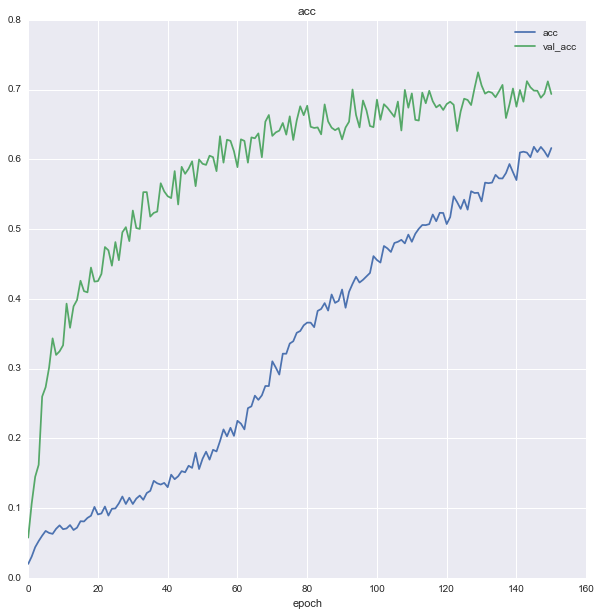

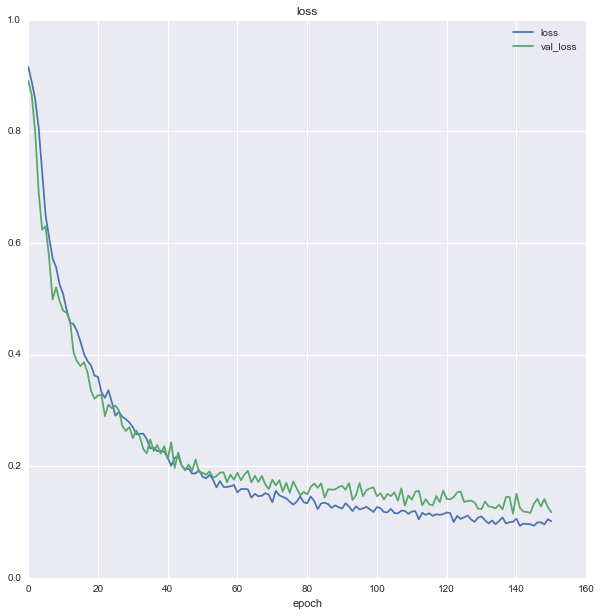

In [95]:
def plot_hist(history):
    """plot keras history object"""
    for label in history.history:
        if not label.startswith('val'):
            plt.title(label)
            plt.plot(history.history[label], label=label)
            if 'val_' + label in history.history:
                plt.plot(history.history['val_' + label], label=label)
            plt.xlabel('epoch')
            plt.show()

plot_hist(model.history)

## Results

Note we compare the unugumented training and unugumented testing data to see if it overfits. If we compared the augumented and unaugumented we would get strange results like more accuracy on the validation data than the test data, but this is due to artificially increased variance on the augumented training data.

In [46]:
# remove dropout
model = unet_inception_model(optimiser,img_cols,img_rows,LeakyReLU,dropout=0.0)

# load best checkpoint
model.load_weights('models/%s_weights.hdf5'%model_name)

# or load pre-trained model
# model.load_weights('models/unet_inception_inv2_20160927-05-11-02_acc-0.70_weights.hdf5')

In [47]:
score = model.evaluate_generator(test_gen, val_samples=batch_size)
score=dict(zip(model.metrics_names,score))
print(score)

{'acc': 0.70276403033694024, 'loss': 0.10917609349729204}


In [48]:
score = model.evaluate_generator(train_gen_unaugumented, val_samples=batch_size)
score=dict(zip(model.metrics_names,score))
print(score)

{'acc': 0.71395832896232603, 'loss': 0.074744646375377977}


In [61]:
X_test, y_test = next(test_gen)
y_pred = model.predict(X_test)

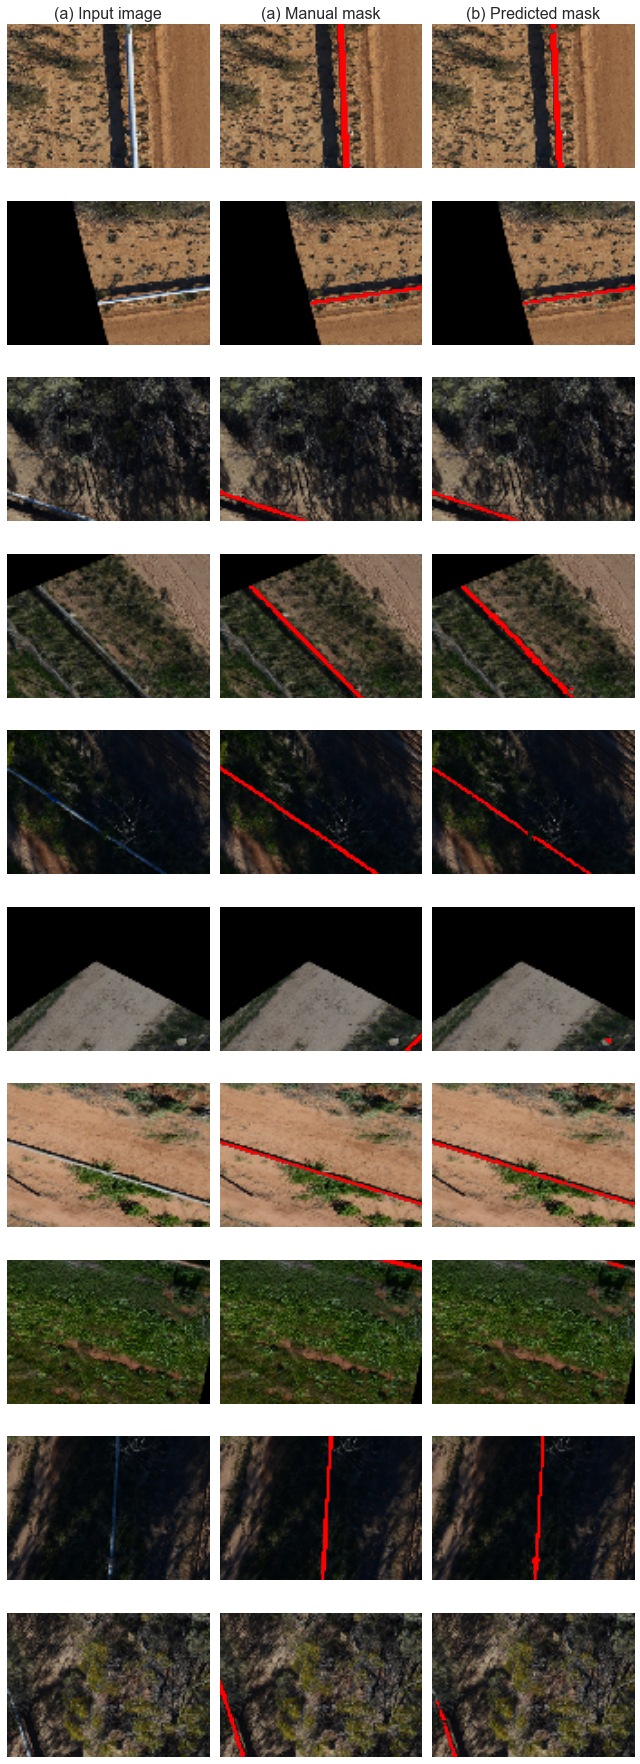

In [62]:
from matplotlib.colors import LogNorm
norm=LogNorm(vmin=1e-3, vmax=1.0)
sns.set_style("dark")
n=10
plt.figure(figsize=(9,2.5*n))


fontsize=16
for i in range(n):
    
    ax=plt.subplot(n,3,1+i*3)
    if i==0: plt.title('(a) Input image', fontsize=fontsize)
    plt.imshow(np.transpose(X_test,(0,2,3,1))[i])
    plt.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax=plt.subplot(n,3,2+i*3)
    if i==0: plt.title('(a) Manual mask', fontsize=fontsize)
    plt.imshow(np.transpose(X_test,(0,2,3,1))[i])
    cm=plt.imshow(y_test[i]>0.5, norm=norm, alpha=1, cmap=plt.cm.rainbow)
    plt.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax=plt.subplot(n,3,3+i*3)
    if i==0: plt.title('(b) Predicted mask', fontsize=fontsize)
    plt.imshow(np.transpose(X_test,(0,2,3,1))[i])
    cm=plt.imshow(y_pred[i]>0.5, norm=norm, alpha=1, cmap=plt.cm.rainbow)
    plt.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.savefig('images/results.png')
plt.show()
